Using device: mps
 Oak: 18 files
 Douglas Fir: 116 files
 Spruce: 117 files
 Pine: 8 files
 Ash: 20 files
 Red Oak: 81 files
 Beech: 70 files
 Total: 430 files across 7 species
 Oak: 4 files
 Douglas Fir: 29 files
 Spruce: 25 files
 Pine: 1 files
 Ash: 7 files
 Red Oak: 19 files
 Beech: 17 files
 Total: 102 files across 7 species
 Split: Train=344, Val=86, Test=102
 Loaders ready. Sample shape: torch.Size([8, 6, 1, 224, 224]) (B, views, C, H, W)
 Model: 2,778,311 params
Epoch  1/100 | Train Loss: 1.9955 Acc: 27.33% | Val Loss: 1.9259 Acc: 22.09%
  New best val acc: 22.09% - Model saved 🚩
Epoch  2/100 | Train Loss: 1.8372 Acc: 29.65% | Val Loss: 1.7552 Acc: 40.70%
  New best val acc: 40.70% - Model saved 🚩
Epoch  3/100 | Train Loss: 1.8237 Acc: 33.43% | Val Loss: 1.7803 Acc: 37.21%
Epoch  4/100 | Train Loss: 1.7310 Acc: 37.50% | Val Loss: 1.6661 Acc: 46.51%
  New best val acc: 46.51% - Model saved 🚩
Epoch  5/100 | Train Loss: 1.6868 Acc: 44.77% | Val Loss: 1.6205 Acc: 36.05%
Epoch  6/10

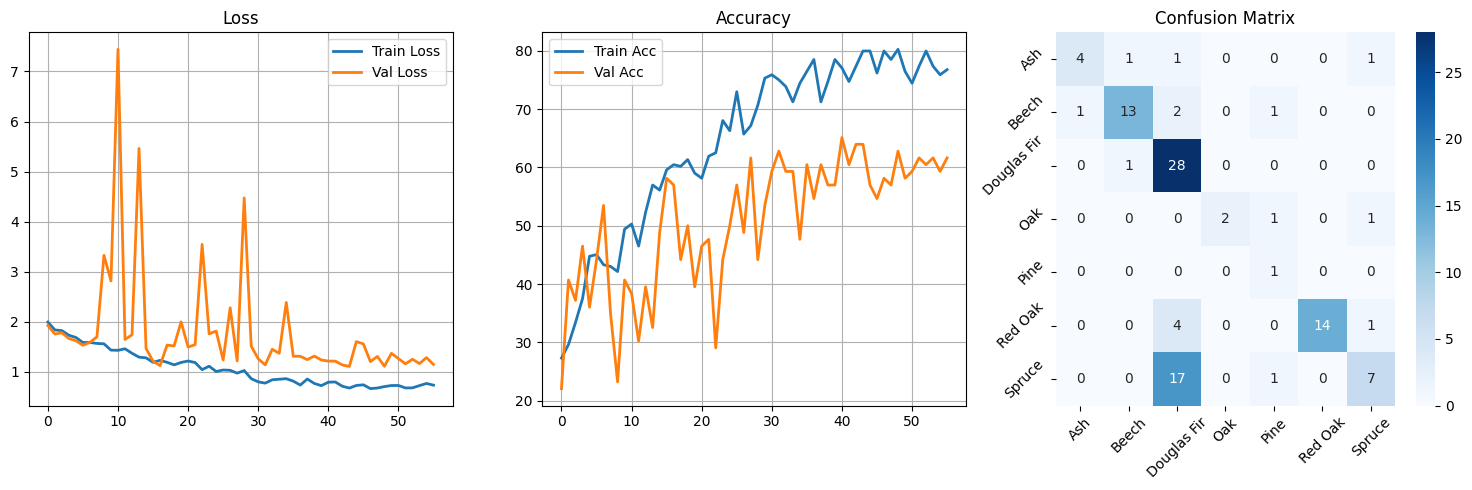

In [13]:
# Cell 1: Imports and Configuration
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, RandomRotation, ColorJitter, RandomHorizontalFlip, RandomResizedCrop
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import Counter
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Configuration
IMG_SIZE = 224
BATCH_SIZE = 8
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
PATIENCE = 15  # Early stopping patience
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")


# Cell 2: Load Data
def load_tree_data(data_path):
    data_path = Path(data_path)
    file_paths = []
    labels = []

    if not data_path.exists():
        raise FileNotFoundError(f"{data_path} not found!")

    for species_dir in data_path.iterdir():
        if species_dir.is_dir():
            species_name = species_dir.name
            files = list(species_dir.glob("*.npy"))
            print(f" {species_name}: {len(files)} files")
            file_paths.extend(files)
            labels.extend([species_name] * len(files))

    print(f" Total: {len(file_paths)} files across {len(set(labels))} species")
    return file_paths, labels

# Load train and test separately
train_data_path = Path("../data/multi_view_images/train")
test_data_path = Path("../data/multi_view_images/test")

train_file_paths, train_labels = load_tree_data(train_data_path)
test_file_paths, test_labels = load_tree_data(test_data_path)

if len(train_file_paths) == 0 or len(test_file_paths) == 0:
    raise ValueError("No data found!")

# Encode labels
label_encoder = LabelEncoder()
all_labels = train_labels + test_labels  # Fit on all for consistency
label_encoder.fit(all_labels)
train_encoded_labels = label_encoder.transform(train_labels)
test_encoded_labels = label_encoder.transform(test_labels)
num_classes = len(label_encoder.classes_)

# Split train into train/val (stratified)
train_paths, val_paths, train_labels_enc, val_labels_enc = train_test_split(
    train_file_paths, train_encoded_labels, test_size=0.2, random_state=42, stratify=train_encoded_labels
)

print(f" Split: Train={len(train_paths)}, Val={len(val_paths)}, Test={len(test_file_paths)}")


# Cell 3: Dataset
class TreeMultiViewDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None, img_size=224):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        self.img_size = img_size

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Load .npy file: shape (num_views, H, W) float [0,1]
        views_arr = np.load(self.file_paths[idx])
        # Convert to list of PIL Images (grayscale)
        images = [Image.fromarray((view * 255).astype(np.uint8), mode='L') for view in views_arr]
        
        if self.transform:
            images = [self.transform(img) for img in images]
        
        # Stack: (num_views, 1, H, W)
        image_stack = torch.stack(images, dim=0)
        label = self.labels[idx]
        return image_stack, label
    
# Enhanced Transforms
train_transform = Compose([
    RandomResizedCrop(size=IMG_SIZE, scale=(0.8, 1.0)),
    RandomHorizontalFlip(),
    RandomRotation(15),
    ColorJitter(brightness=0.2, contrast=0.2),
    ToTensor(),
    Normalize(mean=[0.5], std=[0.5])
])

test_transform = Compose([
    Resize((IMG_SIZE, IMG_SIZE)),
    ToTensor(),
    Normalize(mean=[0.5], std=[0.5])
])

# Datasets
train_dataset = TreeMultiViewDataset(train_paths, train_labels_enc, train_transform)
val_dataset = TreeMultiViewDataset(val_paths, val_labels_enc, test_transform)
test_dataset = TreeMultiViewDataset(test_file_paths, test_encoded_labels, test_transform)

# Loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Check sample shape
sample_shape = next(iter(train_loader))[0].shape
print(f" Loaders ready. Sample shape: {sample_shape} (B, views, C, H, W)")

# Cell 4: Model
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return self.relu(out)

class MultiViewCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2, 1),
            BasicBlock(64, 64),
            BasicBlock(64, 64),
            BasicBlock(64, 128, 2),
            BasicBlock(128, 128),
            BasicBlock(128, 256, 2),
            BasicBlock(256, 256),
            nn.AdaptiveAvgPool2d(1)
        )
        self.dropout = nn.Dropout(p=0.5)  # Added dropout for regularization
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, x):
        # Input: (B, views, 1, H, W)
        if x.dim() == 5:
            b, views, c, h, w = x.shape
        else:
            raise ValueError(f"Unexpected input tensor shape {x.shape}")

        x = x.view(-1, c, h, w)  # (B*views, 1, H, W)
        x = self.features(x)     # (B*views, 256, 1, 1)
        x = x.view(b, views, -1) # (B, views, 256)
        x = x.mean(dim=1)        # (B, 256)
        x = self.dropout(x)      # Dropout before classifier
        return self.classifier(x)

# Model
model = MultiViewCNN(num_classes).to(DEVICE)

# Weighted loss for imbalance
class_weights = [1.0 / Counter(train_labels_enc)[i] for i in range(num_classes)]
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(DEVICE))

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# Improved scheduler: ReduceLROnPlateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

print(f" Model: {sum(p.numel() for p in model.parameters()):,} params")


# Cell 5: Training Loop with Early Stopping
def train_model(model, train_loader, val_loader, epochs, patience):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_acc = 0.0
    patience_counter = 0
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        loss_meter = 0.0
        correct = 0
        total = 0

        for views, labels in train_loader:
            views, labels = views.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(views)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            loss_meter += loss.item()
            _, pred = outputs.max(1)
            total += labels.size(0)
            correct += pred.eq(labels).sum().item()

        train_loss = loss_meter / len(train_loader)
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for views, labels in val_loader:
                views, labels = views.to(DEVICE), labels.to(DEVICE)
                outputs = model(views)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, pred = outputs.max(1)
                val_total += labels.size(0)
                val_correct += pred.eq(labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100. * val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Scheduler step
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1:2d}/{epochs} | Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}%")

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pt')
            patience_counter = 0
            print(f"  New best val acc: {best_acc:.2f}% - Model saved 🚩")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    print(f"Training done in {time.time() - start_time:.2f}s")
    return train_losses, val_losses, train_accs, val_accs, best_acc

# Train
train_losses, val_losses, train_accs, val_accs, best_val_acc = train_model(model, train_loader, val_loader, NUM_EPOCHS, PATIENCE)

# Cell 6: Evaluate on Test Set with Best Model
def evaluate(model, loader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for views, labels in loader:
            views, labels = views.to(DEVICE), labels.to(DEVICE)
            outputs = model(views)
            _, pred = outputs.max(1)
            preds.append(pred.cpu())
            targets.append(labels.cpu())
    return torch.cat(preds).numpy(), torch.cat(targets).numpy()

# Load best model
model.load_state_dict(torch.load('best_model.pt'))
print("Best model loaded for evaluation")

y_pred, y_true = evaluate(model, test_loader)
test_acc = accuracy_score(y_true, y_pred) * 100

print(f"\n Final Test Accuracy: {test_acc:.2f}%")
print(f"Best Val Accuracy: {best_val_acc:.2f}%")

# Report
names = label_encoder.classes_
print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=names))

# Plots
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label="Train Loss", lw=2)
plt.plot(val_losses, label="Val Loss", lw=2)
plt.legend(); plt.title("Loss"); plt.grid()

plt.subplot(1, 3, 2)
plt.plot(train_accs, label="Train Acc", lw=2)
plt.plot(val_accs, label="Val Acc", lw=2)
plt.legend(); plt.title("Accuracy"); plt.grid()

plt.subplot(1, 3, 3)
cm = confusion_matrix(y_true, y_pred, labels=range(len(names)))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=names, yticklabels=names)
plt.title("Confusion Matrix"); plt.xticks(rotation=45); plt.yticks(rotation=45)
plt.tight_layout(); plt.show()